<a href="https://colab.research.google.com/github/rayan239/Computer_Vision/blob/main/garbage_df.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Working dir
import os, pathlib, sys, random, numpy as np, tensorflow as tf
WORK_DIR = '/content/garbage_project'
os.makedirs(WORK_DIR, exist_ok=True)
%cd $WORK_DIR


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/garbage_project


In [3]:

print("TensorFlow:", tf.__version__)
print("GPU:", tf.config.list_physical_devices('GPU'))

# (Optional) speed opts — safe on most Colab runtimes
try:
    tf.config.optimizer.set_jit(True)   # XLA
except Exception as e:
    print("XLA not enabled:", e)
try:
    from tensorflow.keras.mixed_precision import set_global_policy
    set_global_policy("mixed_float16")  # automatic loss scaling on GPU
    print("Mixed precision enabled.")
except Exception as e:
    print("Mixed precision not enabled:", e)

TensorFlow: 2.19.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Mixed precision enabled.


Total valid images: 19775  | Skipped bad/non-images: 0
Classes: ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']


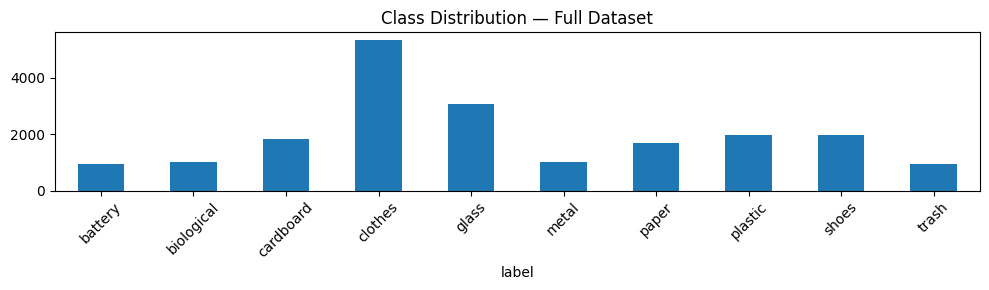

In [4]:
# =========================
# Colab cell 2: Point to dataset dir
# =========================
from pathlib import Path
from PIL import Image, UnidentifiedImageError
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

# If using Kaggle: auto-discover class root
def find_class_root(base: Path, target_classes):
    targets = set(c.lower() for c in target_classes)
    for p in [base] + list(base.rglob("*")):
        if p.is_dir():
            subs = [d.name.lower() for d in p.iterdir() if d.is_dir()]
            if len(set(subs) & targets) >= 9:
                return p
    return base

TARGET_CLASSES = ["battery","biological","cardboard","clothes","glass","metal","paper","plastic","shoes","trash"]
ALLOWED_EXTS   = {".jpg",".jpeg",".png",".bmp",".webp",".jfif"}

    # 👇 change this to your Drive dataset folder if not using Kaggle
DATA_DIR = Path('/content/drive/MyDrive/garbage-dataset')


# Enumerate files, filter non-images & corrupts
all_rows, bad_files = [], []
for cls_dir in sorted([d for d in DATA_DIR.iterdir() if d.is_dir()]):
    cname = cls_dir.name.lower()
    if cname not in [c.lower() for c in TARGET_CLASSES]:
        continue
    for f in cls_dir.rglob("*"):
        if f.is_file() and f.suffix.lower() in ALLOWED_EXTS:
            try:
                with Image.open(f) as im: im.verify()
                all_rows.append({"filepath": str(f), "label": cls_dir.name})
            except (UnidentifiedImageError, OSError, ValueError):
                bad_files.append(str(f))
        elif f.is_file():
            bad_files.append(str(f))

df_all = pd.DataFrame(all_rows)
print("Total valid images:", len(df_all), " | Skipped bad/non-images:", len(bad_files))

# Class list & counts
classes = sorted(df_all['label'].unique().tolist())
print("Classes:", classes)
cnt = df_all['label'].value_counts().loc[classes]
cnt.plot(kind="bar", figsize=(10,3), title="Class Distribution — Full Dataset")
plt.xticks(rotation=45); plt.tight_layout(); plt.show()


Train: (15820, 2)  Val: (1977, 2)  Test: (1978, 2)


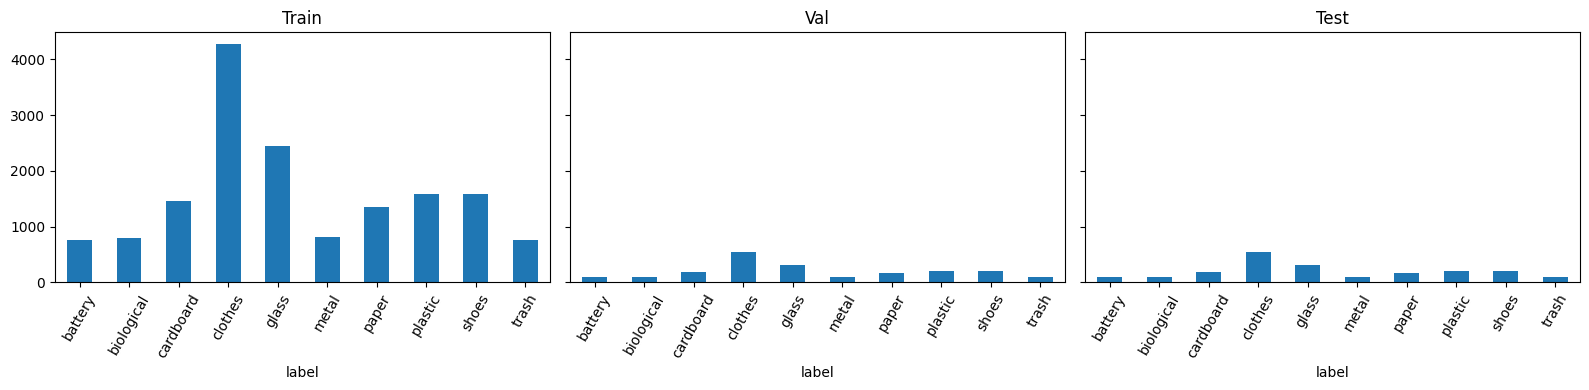

Saved splits to ./splits/ (include in paper supplementary).


In [5]:
# =========================
# Colab cell 3: Stratified 80/10/10 split
# =========================
from sklearn.model_selection import train_test_split
import os

SEED = 42
train_df, temp_df = train_test_split(df_all, test_size=0.20, stratify=df_all['label'], random_state=SEED)
val_df,   test_df = train_test_split(temp_df, test_size=0.50, stratify=temp_df['label'], random_state=SEED)

print("Train:", train_df.shape, " Val:", val_df.shape, " Test:", test_df.shape)

# Save CSVs (reproducibility)
os.makedirs("splits", exist_ok=True)
train_df.to_csv("splits/train.csv", index=False)
val_df.to_csv("splits/val.csv", index=False)
test_df.to_csv("splits/test.csv", index=False)

# Class distribution in each split
fig, axes = plt.subplots(1,3, figsize=(16,4), sharey=True)
for ax, df, title in zip(axes, [train_df,val_df,test_df], ["Train","Val","Test"]):
    counts = df['label'].value_counts().loc[classes]
    counts.plot(kind="bar", ax=ax, title=title)
    ax.tick_params(axis='x', rotation=60)
plt.tight_layout(); plt.show()

print("Saved splits to ./splits/ (include in paper supplementary).")


In [6]:
# =========================
# Colab cell 4: tf.data pipelines
# =========================
import tensorflow as tf
import numpy as np # Added import for numpy
AUTOTUNE = tf.data.AUTOTUNE
IMG_SIZE = 224
BATCH_SIZE = 32

# Label mapping
class_to_index = {c:i for i,c in enumerate(classes)}
index_to_class = {i:c for c,i in class_to_index.items()}

def df_to_dataset(df, shuffle=True, augment=False, cache=False):
    paths  = df['filepath'].values
    labels = df['label'].map(class_to_index).astype(np.int32).values
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(min(len(paths), 4000), seed=SEED, reshuffle_each_iteration=True)
    def _load(path, label):
        img_b = tf.io.read_file(path)
        img   = tf.io.decode_image(img_b, channels=3, expand_animations=False)   # force RGB
        img.set_shape([None, None, 3])
        img   = tf.image.resize(img, [IMG_SIZE, IMG_SIZE], method="bilinear")
        img   = tf.cast(img, tf.float32)  # keep 0..255; model preprocess will scale
        return img, label
    ds = ds.map(_load, num_parallel_calls=AUTOTUNE)

    # Augment (train only): safe, fast ops
    aug = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.08),
        tf.keras.layers.RandomZoom(0.10),
        tf.keras.layers.RandomContrast(0.10),
    ], name="augment")
    def _aug(x,y):
        # brightness jitter in [0..255]
        x = tf.image.random_brightness(x, max_delta=20.0)
        x = tf.clip_by_value(x, 0.0, 255.0)
        x = aug(x, training=True)
        return x, y
    if augment:
        ds = ds.map(_aug, num_parallel_calls=AUTOTUNE)

    ds = ds.batch(BATCH_SIZE, drop_remainder=False)
    if cache: ds = ds.cache()
    ds = ds.prefetch(AUTOTUNE)
    try:
        ds = ds.apply(tf.data.experimental.ignore_errors())
    except: pass
    return ds

train_ds = df_to_dataset(train_df, shuffle=True,  augment=True,  cache=False)
val_ds   = df_to_dataset(val_df,   shuffle=False, augment=False, cache=False)
test_ds  = df_to_dataset(test_df,  shuffle=False, augment=False, cache=False)

for imgs, labs in train_ds.take(1):
    print("Sanity batch:", imgs.shape, labs.shape, imgs.dtype)

Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


Sanity batch: (32, 224, 224, 3) (32,) <dtype: 'float16'>


In [7]:
# =========================
# Colab cell 5: Class weights
# =========================
from sklearn.utils.class_weight import compute_class_weight
y_train = train_df['label'].map(class_to_index).values
cw = compute_class_weight(class_weight='balanced',
                          classes=np.arange(len(classes)),
                          y=y_train)
CLASS_WEIGHTS = {i: float(w) for i,w in enumerate(cw)}
print("Class weights:", {index_to_class[i]: round(w,3) for i,w in CLASS_WEIGHTS.items()})


Class weights: {'battery': 2.095, 'biological': 1.982, 'cardboard': 1.084, 'clothes': 0.37, 'glass': 0.646, 'metal': 1.939, 'paper': 1.177, 'plastic': 0.997, 'shoes': 1.001, 'trash': 2.087}


In [8]:
# =========================
# Colab cell 6: Model build (EfficientNetB0)
# =========================
from tensorflow.keras import layers, models, optimizers

from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input as eff_preprocess

def build_efficientnet_b0(input_shape=(IMG_SIZE,IMG_SIZE,3), num_classes=len(classes), dropout=0.4):
    inputs = layers.Input(shape=input_shape, name="image")
    x = layers.Lambda(eff_preprocess, name="preprocess")(inputs)  # expects 0..255 input
    base = EfficientNetB0(include_top=False, weights="imagenet", input_shape=input_shape)
    base.trainable = False
    x = base(x)                                   # keep BN frozen while base is frozen
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(num_classes, activation='softmax', dtype="float32")(x)  # force float32 head if mixed precision
    model = models.Model(inputs, outputs, name="EfficientNetB0_Garbage")
    # convenient handles
    model._base = base
    model._unfreeze_k = 25
    model.summary(line_length=110)
    trainable = np.sum([np.prod(v.shape) for v in model.trainable_weights])
    nontrain  = np.sum([np.prod(v.shape) for v in model.non_trainable_weights])
    print(f"Trainable params: {trainable:,} | Non-trainable: {nontrain:,}")
    return model

model = build_efficientnet_b0()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "EfficientNetB0_Garbage"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                   ┃ Output Shape                        ┃             Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)                             │ (None, 224, 224, 3)                 │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ preprocess (Lambda)                            │ (None, 224, 224, 3)                 │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ efficientnetb0 (Functional)                    │ (None, 7, 7, 1280)                  │           4,049,571 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ global_average_pooling2d                       │ (None, 1280)                        │                   0 │
│ (GlobalAveragePooling2D)                       │                                     │                     │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout (Dropout)                              │ (None, 1280)                        │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dense (Dense)                                  │ (None, 10)                          │              12,810 │
└────────────────────────────────────────────────┴─────────────────────────────────────┴─────────────────────┘

 Total params: 4,062,381 (15.50 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Trainable params: 12,810 | Non-trainable: 4,049,571.0


In [9]:
# =========================
# Colab cell 7: Stage A training (head only)
# =========================
import time
class EpochTimer(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None): self.times=[]
    def on_epoch_begin(self, epoch, logs=None): self._t=time.time()
    def on_epoch_end(self, epoch, logs=None): self.times.append(time.time()-self._t)

EPOCHS_STAGE1 = 10
timerA = EpochTimer()
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
cbA = [
    tf.keras.callbacks.ModelCheckpoint("best_stage1.h5", monitor="val_loss", save_best_only=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-7, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1),
    timerA
]
histA = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS_STAGE1,
                  class_weight=CLASS_WEIGHTS, callbacks=cbA, verbose=1)


Epoch 1/10
    492/Unknown 480s 853ms/step - accuracy: 0.7251 - loss: 1.0183

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_loss improved from inf to 0.25307, saving model to best_stage1.h5


492/492 ━━━━━━━━━━━━━━━━━━━━ 547s 989ms/step - accuracy: 0.7253 - loss: 1.0175 - val_accuracy: 0.9191 - val_loss: 0.2531 - learning_rate: 0.0010
Epoch 2/10
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - accuracy: 0.8968 - loss: 0.3596
Epoch 2: val_loss improved from 0.25307 to 0.20687, saving model to best_stage1.h5


492/492 ━━━━━━━━━━━━━━━━━━━━ 290s 589ms/step - accuracy: 0.8968 - loss: 0.3595 - val_accuracy: 0.9307 - val_loss: 0.2069 - learning_rate: 0.0010
Epoch 3/10
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 567ms/step - accuracy: 0.9075 - loss: 0.3152
Epoch 3: val_loss improved from 0.20687 to 0.19319, saving model to best_stage1.h5


492/492 ━━━━━━━━━━━━━━━━━━━━ 288s 584ms/step - accuracy: 0.9075 - loss: 0.3152 - val_accuracy: 0.9383 - val_loss: 0.1932 - learning_rate: 0.0010
Epoch 4/10
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 570ms/step - accuracy: 0.9162 - loss: 0.2832
Epoch 4: val_loss improved from 0.19319 to 0.17745, saving model to best_stage1.h5


492/492 ━━━━━━━━━━━━━━━━━━━━ 288s 586ms/step - accuracy: 0.9162 - loss: 0.2832 - val_accuracy: 0.9408 - val_loss: 0.1774 - learning_rate: 0.0010
Epoch 5/10
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - accuracy: 0.9215 - loss: 0.2600
Epoch 5: val_loss did not improve from 0.17745
492/492 ━━━━━━━━━━━━━━━━━━━━ 322s 586ms/step - accuracy: 0.9215 - loss: 0.2600 - val_accuracy: 0.9413 - val_loss: 0.1835 - learning_rate: 0.0010
Epoch 6/10
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - accuracy: 0.9248 - loss: 0.2511
Epoch 6: val_loss did not improve from 0.17745

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
492/492 ━━━━━━━━━━━━━━━━━━━━ 287s 583ms/step - accuracy: 0.9248 - loss: 0.2511 - val_accuracy: 0.9408 - val_loss: 0.1819 - learning_rate: 0.0010
Epoch 7/10
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - accuracy: 0.9279 - loss: 0.2315
Epoch 7: val_loss improved from 0.17745 to 0.17133, saving model to best_stage1.h5


492/492 ━━━━━━━━━━━━━━━━━━━━ 347s 706ms/step - accuracy: 0.9279 - loss: 0.2315 - val_accuracy: 0.9454 - val_loss: 0.1713 - learning_rate: 5.0000e-04
Epoch 8/10
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - accuracy: 0.9294 - loss: 0.2328
Epoch 8: val_loss improved from 0.17133 to 0.16455, saving model to best_stage1.h5


492/492 ━━━━━━━━━━━━━━━━━━━━ 304s 617ms/step - accuracy: 0.9294 - loss: 0.2328 - val_accuracy: 0.9494 - val_loss: 0.1646 - learning_rate: 5.0000e-04
Epoch 9/10
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 600ms/step - accuracy: 0.9289 - loss: 0.2315
Epoch 9: val_loss did not improve from 0.16455
492/492 ━━━━━━━━━━━━━━━━━━━━ 304s 618ms/step - accuracy: 0.9289 - loss: 0.2315 - val_accuracy: 0.9489 - val_loss: 0.1664 - learning_rate: 5.0000e-04
Epoch 10/10
493/492 ━━━━━━━━━━━━━━━━━━━━ 0s 592ms/step - accuracy: 0.9313 - loss: 0.2290
Epoch 10: val_loss did not improve from 0.16455

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
492/492 ━━━━━━━━━━━━━━━━━━━━ 300s 610ms/step - accuracy: 0.9313 - loss: 0.2290 - val_accuracy: 0.9499 - val_loss: 0.1659 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 8.


In [10]:
# =========================
# Colab cell 8: Stage B fine-tuning (top layers)
# =========================
# Unfreeze top-k layers of the base
k = model._unfreeze_k
model._base.trainable = True
for layer in model._base.layers[:-k]:
    layer.trainable = False
for layer in model._base.layers[-k:]:
    layer.trainable = True

EPOCHS_STAGE2 = 10
timerB = EpochTimer()
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
cbB = [
    tf.keras.callbacks.ModelCheckpoint("best_finetuned.h5", monitor="val_loss", save_best_only=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-7, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1),
    timerB
]
histB = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS_STAGE2,
                  class_weight=CLASS_WEIGHTS, callbacks=cbB, verbose=1)

# Save final model
model.save("final_model.h5")
print("Saved final_model.h5")


Epoch 1/10
    492/Unknown 372s 653ms/step - accuracy: 0.8572 - loss: 0.4619
Epoch 1: val_loss improved from inf to 0.22126, saving model to best_finetuned.h5


492/492 ━━━━━━━━━━━━━━━━━━━━ 417s 745ms/step - accuracy: 0.8572 - loss: 0.4619 - val_accuracy: 0.9353 - val_loss: 0.2213 - learning_rate: 1.0000e-05
Epoch 2/10
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - accuracy: 0.8912 - loss: 0.3527
Epoch 2: val_loss improved from 0.22126 to 0.19864, saving model to best_finetuned.h5


492/492 ━━━━━━━━━━━━━━━━━━━━ 304s 618ms/step - accuracy: 0.8912 - loss: 0.3527 - val_accuracy: 0.9393 - val_loss: 0.1986 - learning_rate: 1.0000e-05
Epoch 3/10
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 602ms/step - accuracy: 0.9009 - loss: 0.3130
Epoch 3: val_loss improved from 0.19864 to 0.18646, saving model to best_finetuned.h5


492/492 ━━━━━━━━━━━━━━━━━━━━ 305s 620ms/step - accuracy: 0.9009 - loss: 0.3130 - val_accuracy: 0.9439 - val_loss: 0.1865 - learning_rate: 1.0000e-05
Epoch 4/10
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 608ms/step - accuracy: 0.9050 - loss: 0.3039
Epoch 4: val_loss improved from 0.18646 to 0.17679, saving model to best_finetuned.h5


492/492 ━━━━━━━━━━━━━━━━━━━━ 309s 627ms/step - accuracy: 0.9050 - loss: 0.3039 - val_accuracy: 0.9449 - val_loss: 0.1768 - learning_rate: 1.0000e-05
Epoch 5/10
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 596ms/step - accuracy: 0.9077 - loss: 0.2927
Epoch 5: val_loss improved from 0.17679 to 0.17022, saving model to best_finetuned.h5


492/492 ━━━━━━━━━━━━━━━━━━━━ 316s 614ms/step - accuracy: 0.9077 - loss: 0.2927 - val_accuracy: 0.9459 - val_loss: 0.1702 - learning_rate: 1.0000e-05
Epoch 6/10
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step - accuracy: 0.9189 - loss: 0.2673
Epoch 6: val_loss improved from 0.17022 to 0.16510, saving model to best_finetuned.h5


492/492 ━━━━━━━━━━━━━━━━━━━━ 321s 652ms/step - accuracy: 0.9189 - loss: 0.2673 - val_accuracy: 0.9464 - val_loss: 0.1651 - learning_rate: 1.0000e-05
Epoch 7/10
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.9205 - loss: 0.2461
Epoch 7: val_loss improved from 0.16510 to 0.15859, saving model to best_finetuned.h5


492/492 ━━━━━━━━━━━━━━━━━━━━ 291s 591ms/step - accuracy: 0.9205 - loss: 0.2461 - val_accuracy: 0.9514 - val_loss: 0.1586 - learning_rate: 1.0000e-05
Epoch 8/10
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.9245 - loss: 0.2348
Epoch 8: val_loss improved from 0.15859 to 0.15619, saving model to best_finetuned.h5


492/492 ━━━━━━━━━━━━━━━━━━━━ 290s 589ms/step - accuracy: 0.9245 - loss: 0.2348 - val_accuracy: 0.9519 - val_loss: 0.1562 - learning_rate: 1.0000e-05
Epoch 9/10
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.9228 - loss: 0.2358
Epoch 9: val_loss improved from 0.15619 to 0.15207, saving model to best_finetuned.h5


492/492 ━━━━━━━━━━━━━━━━━━━━ 323s 591ms/step - accuracy: 0.9228 - loss: 0.2358 - val_accuracy: 0.9499 - val_loss: 0.1521 - learning_rate: 1.0000e-05
Epoch 10/10
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 570ms/step - accuracy: 0.9299 - loss: 0.2283
Epoch 10: val_loss improved from 0.15207 to 0.14941, saving model to best_finetuned.h5


492/492 ━━━━━━━━━━━━━━━━━━━━ 320s 588ms/step - accuracy: 0.9299 - loss: 0.2283 - val_accuracy: 0.9525 - val_loss: 0.1494 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 10.


Saved final_model.h5



Test Accuracy: 0.9434  |  Macro-Precision: 0.9273  Macro-Recall: 0.9431  Macro-F1: 0.9340

              precision    recall  f1-score   support

     battery     0.9681    0.9681    0.9681        94
  biological     0.9429    0.9900    0.9659       100
   cardboard     0.9247    0.9399    0.9322       183
     clothes     0.9905    0.9719    0.9811       534
       glass     0.9652    0.9052    0.9342       306
       metal     0.7778    0.9608    0.8596       102
       paper     0.9444    0.9107    0.9273       168
     plastic     0.9175    0.8945    0.9059       199
       shoes     0.9461    0.9747    0.9602       198
       trash     0.8958    0.9149    0.9053        94

    accuracy                         0.9434      1978
   macro avg     0.9273    0.9431    0.9340      1978
weighted avg     0.9458    0.9434    0.9438      1978



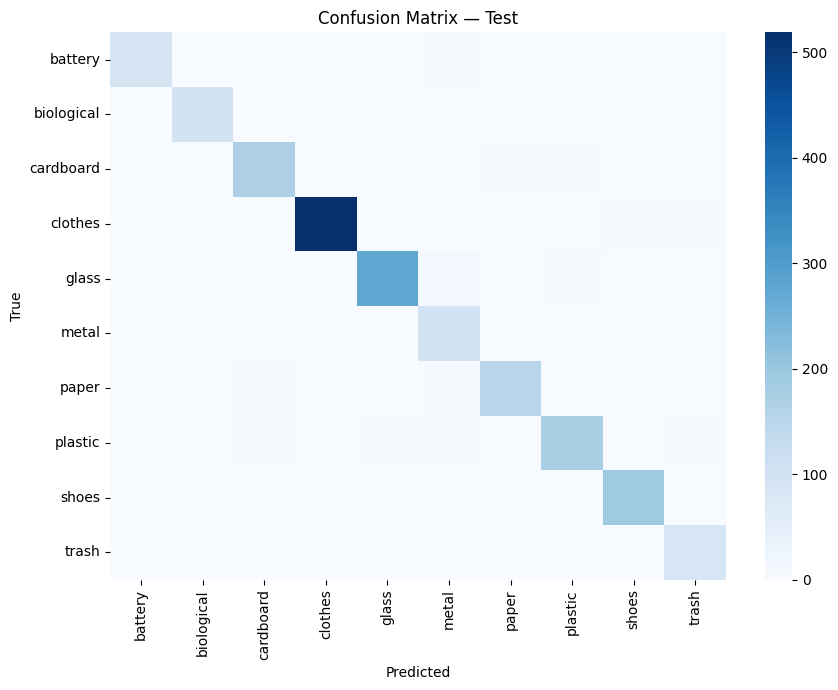

Avg time/epoch (approx): 323.70s
Model size (H5): 27.23 MB


In [11]:
# =========================
# Colab cell 9: Evaluation
# =========================
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Inference on test
y_true, y_pred = [], []
for x_batch, y_batch in test_ds:
    preds = model.predict(x_batch, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1).tolist())
    y_true.extend(y_batch.numpy().tolist())

y_true = np.array(y_true); y_pred = np.array(y_pred)
acc = accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="macro", zero_division=0)

print(f"\nTest Accuracy: {acc:.4f}  |  Macro-Precision: {prec:.4f}  Macro-Recall: {rec:.4f}  Macro-F1: {f1:.4f}\n")
print(classification_report(y_true, y_pred, target_names=classes, digits=4))

# Confusion matrix (normalized for readability)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(9,7))
sns.heatmap(cm, cmap="Blues", xticklabels=classes, yticklabels=classes, cbar=True)
plt.title("Confusion Matrix — Test"); plt.xlabel("Predicted"); plt.ylabel("True"); plt.tight_layout(); plt.show()

# Per-class metrics CSV (for the paper)
p_i, r_i, f1_i, sup_i = precision_recall_fscore_support(y_true, y_pred, labels=range(len(classes)), zero_division=0)
df_metrics = pd.DataFrame({"class": classes, "precision": p_i, "recall": r_i, "f1": f1_i, "support": sup_i})
df_metrics.to_csv("per_class_metrics.csv", index=False); df_metrics.head()

# Time per epoch & model size
def path_size_mb(path):
    import os
    if os.path.isfile(path): return os.path.getsize(path)/(1024*1024)
    total=0
    for r,_,fs in os.walk(path):
        for f in fs: total += os.path.getsize(os.path.join(r,f))
    return total/(1024*1024)

avg_time_epoch = float(np.mean(timerA.times + timerB.times)) if (timerA.times or timerB.times) else np.nan
print(f"Avg time/epoch (approx): {avg_time_epoch:.2f}s")
print("Model size (H5):", f"{path_size_mb('final_model.h5'):.2f} MB")
